In [1]:
from train_utils import *
import torch
from torch.utils.data import DataLoader
from dataset.dataset_loader import SNDataset,SNDatasetClimate, myNormalize, myToTensor, Augmentations
from torchvision import transforms
import random
import numpy as np
from dataset.utils.utils import TextColors as tc
from plot_utils.plot import plot_train_test_losses
from datetime import date, datetime
import torch.nn.functional as F
import cv2
import json

In [2]:
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

In [3]:
# Format the date and time
now = datetime.now()
start_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", start_string)

Current Date and Time: 2023-06-09 12:25:54


In [4]:
import os
os.getcwd()

NAFISEH = "Nafiseh"
MOIEN = "Moien"

if "d:" in os.getcwd():
    USER = MOIEN
elif "c:" in os.getcwd():
    USER = NAFISEH
else:
    raise Exception("Unknown user")

USER

'Nafiseh'

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# CONFIG
NUM_WORKERS = 6 if USER == NAFISEH else 2
TRAIN_BATCH_SIZE = 32 if USER == NAFISEH else 4
TEST_BATCH_SIZE = 32 if USER == NAFISEH else 4
LEARNING_RATE = 1e-4 if USER == NAFISEH else 1e-4
NUM_EPOCHS = 17 if USER == NAFISEH else 2
LR_SCHEDULER = "step" # step, plateau or None

OC_MAX = 87
USE_SRTM = True

USE_SPATIAL_ATTENTION = True if USER == NAFISEH else True
RESNET_VERSION = 'v1' # v1 or v2
REG_VERSION = 1 if USER == NAFISEH else 2
USE_LSTM_BRANCH = False

In [7]:

if USE_SRTM:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)], [(12), (-4,2963)], [(13), (0, 90)]], oc_min = 0, oc_max = OC_MAX)
else:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)]], oc_min = 0, oc_max = OC_MAX)
    
my_to_tensor = myToTensor()
my_augmentation = Augmentations()
train_transform = transforms.Compose([mynorm, my_to_tensor,my_augmentation])
test_transform = transforms.Compose([mynorm, my_to_tensor])

In [8]:
if USER == MOIEN:
    train_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\train\\'
    test_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\test\\'
    val_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\val\\'
    lucas_csv_path = 'D:\python\SoilNet\dataset\LUCAS_2015_all.csv'
    climate_csv_folder_path = "D:\\python\\SoilNet\\dataset\\Climate\\All\\filled\\"
    
elif USER == NAFISEH:
    train_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images\\train'
    test_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images\\test'
    val_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images\\val'
    testval_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images\\test_val'
    lucas_csv_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\LUCAS_2015_all.csv'
    climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\Climate\\All\\filled'

In [9]:
bands = [0,1,2,3,4,5,6,7,8,9,10,11] if not USE_SRTM else [0,1,2,3,4,5,6,7,8,9,10,11,12,13]


################################# IF Not USE_LSTM_BRANCH ###############################
if not USE_LSTM_BRANCH: # NOT USING THE CLIMATE DATA

    train_ds = SNDataset(train_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=train_transform)
    test_ds =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    val_ds = SNDataset(val_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    test_ds_w_id =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    testval_ds_w_id =  SNDataset(testval_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    
################################### IF USE_LSTM_BRANCH #################################
else: # USING THE CLIMATE DATA
    train_ds = SNDatasetClimate(train_l8_folder_path,
                                    lucas_csv_path,
                                    climate_csv_folder_path,
                                    l8_bands=bands, transform=train_transform)

    test_ds = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    val_ds = SNDatasetClimate(val_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    test_ds_w_id = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)

    testval_ds_w_id = SNDatasetClimate(testval_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)
    


In [10]:
# COUNTING the csv files in the csv folder
CSV_FILES = [f for f in os.listdir(climate_csv_folder_path) if f.endswith('.csv')]
NUM_CLIMATE_FEATURES = len(CSV_FILES)
NUM_CLIMATE_FEATURES

14

In [11]:
from soilnet.soil_net import ResNet, ResNetLSTM

In [12]:
# train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# # Get image and label from custom DataLoader
# img_custom, climate,label_custom = next(iter(train_dl))
# print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
# print(f"Climate shape: {climate.shape} -> [batch_size, climate_channels]")
# print(f"Label shape: {label_custom.shape}")
# img_gpu = img_custom.to(device)
# print(img_gpu.device, img_gpu.shape)
# print(img_gpu.shape)
# y = model(img_gpu)
# y.detach()

In [13]:
cv_results = {"train_loss": [],
               "val_loss": [],
               "MAE": [],
               "RMSE": [],
               "R2": []
    }

In [14]:
from datetime import date, datetime
# Format the date and time
now = datetime.now()
run_name = now.strftime("D_%Y_%m_%d_T_%H_%M")
print("Current Date and Time:", run_name)
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

Current Date and Time: D_2023_06_09_T_12_25


In [15]:
# SEEDS = [75] 
SEEDS = [1]  if USER == MOIEN else [786, 2048, 3333]
# SEEDS = [1] if USER == MOIEN else [1, 4, 69, 75, 79, 128, 474, 786, 2048, 3333]

In [16]:
best_mae = 1000 # just a big number, since our data is normalized between 0 and 1, mae is between 0 and 1 too.
best_seed = SEEDS[0]
for idx, seed in enumerate(SEEDS):
    print(tc.BOLD_BAKGROUNDs.PURPLE, f"CROSS VAL {idx+1}", tc.ENDC)
    
    
    train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_dl = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    val_dl = DataLoader(val_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    #model = SoilNetFC(cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
    architecture = "101+GLAM" if USE_SPATIAL_ATTENTION else "101"
    if USE_LSTM_BRANCH:
        model = ResNetLSTM(resnet_architecture=architecture, resnet_version= RESNET_VERSION, reg_version= REG_VERSION,
                           cnn_in_channels=len(bands), regresor_input_from_cnn=1024,
                           lstm_n_features= NUM_CLIMATE_FEATURES, lstm_n_layers= 2, lstm_out= 128,
                           hidden_size=128).to(device)
    else:
        model = ResNet(resnet_architecture=architecture, resnet_version= RESNET_VERSION, reg_version= REG_VERSION,
                       cnn_in_channels=len(bands), regresor_input_from_cnn=1024, hidden_size=128).to(device)
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Saving the model on the last epoch
    save_model_path = f"results/RUN_{run_name}_{USER}.pth.tar"
    
    results = train(model, train_dl, test_dl, val_dl,
                    torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
                    RMSELoss(), epochs=NUM_EPOCHS, lr_scheduler=LR_SCHEDULER,
                    save_model_path= save_model_path,
                    save_model_if_mae_lower_than= best_mae,
                    )

    
    cv_results['train_loss'].append(results['train_loss'])
    cv_results['val_loss'].append(results['val_loss'])
    cv_results['MAE'].append(results['MAE'][0])
    cv_results['RMSE'].append(results['RMSE'][0])
    cv_results['R2'].append(results['R2'][0])
    
    if results['MAE'][0] < best_mae:
        best_mae = results['MAE'][0]
        best_seed = seed
        print(tc.BOLD_BAKGROUNDs.GREEN, f"MAE improved to {best_mae}", tc.ENDC)
    
        

 CROSS VAL 1 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 478/478 [00:45<00:00, 10.53it/s, Train_Loss=0.259]


 Epoch 1 Results: |  train_loss: 0.259227468503569 |  val_loss: 0.24982546906972278  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.17it/s, Train_Loss=0.248]


 Epoch 2 Results: |  train_loss: 0.24804306345130608 |  val_loss: 0.24303606141736542  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 478/478 [00:43<00:00, 11.00it/s, Train_Loss=0.246]


 Epoch 3 Results: |  train_loss: 0.24597776578310643 |  val_loss: 0.241666323788788  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.31it/s, Train_Loss=0.243]


 Epoch 4 Results: |  train_loss: 0.2426505572002802 |  val_loss: 0.23687656634095786  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.35it/s, Train_Loss=0.242]


 Epoch 5 Results: |  train_loss: 0.24158073980439157 |  val_loss: 0.24084009500085443  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.22it/s, Train_Loss=0.24] 


 Epoch 6 Results: |  train_loss: 0.24020457545209628 |  val_loss: 0.24248662202254587  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.28it/s, Train_Loss=0.24] 


 Epoch 7 Results: |  train_loss: 0.23955672075309514 |  val_loss: 0.2366765862789707  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.29it/s, Train_Loss=0.239]


 Epoch 8 Results: |  train_loss: 0.23881277869061945 |  val_loss: 0.2354232086867526  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.32it/s, Train_Loss=0.238]


 Epoch 9 Results: |  train_loss: 0.2378592996168336 |  val_loss: 0.24080646923486737  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.28it/s, Train_Loss=0.236]


 Epoch 10 Results: |  train_loss: 0.23648385528989416 |  val_loss: 0.23330057401587997  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 478/478 [00:41<00:00, 11.40it/s, Train_Loss=0.232]


 Epoch 11 Results: |  train_loss: 0.23210248076766105 |  val_loss: 0.22584455168765524  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.38it/s, Train_Loss=0.23] 


 Epoch 12 Results: |  train_loss: 0.2296923220344667 |  val_loss: 0.22700416555871133  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.37it/s, Train_Loss=0.229]


 Epoch 13 Results: |  train_loss: 0.22941432327468525 |  val_loss: 0.22430004740970721  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.33it/s, Train_Loss=0.228]


 Epoch 14 Results: |  train_loss: 0.22816280425218358 |  val_loss: 0.23142789714578269  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 478/478 [00:41<00:00, 11.51it/s, Train_Loss=0.228]


 Epoch 15 Results: |  train_loss: 0.22790175386427836 |  val_loss: 0.22458365041276682  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.29it/s, Train_Loss=0.227]


 Epoch 16 Results: |  train_loss: 0.22678303771562655 |  val_loss: 0.2260284599834594  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.16it/s, Train_Loss=0.226]


 Epoch 17 Results: |  train_loss: 0.22641183164703296 |  val_loss: 0.22470378530198248  

Adjusting learning rate of group 0 to 2.0000e-05.
Saving checkpoint=> Done!
 MAE improved to 0.17406829114813005 
 CROSS VAL 2 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 478/478 [00:43<00:00, 11.00it/s, Train_Loss=0.256]


 Epoch 1 Results: |  train_loss: 0.25562542440003433 |  val_loss: 0.24699478726024213  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.17it/s, Train_Loss=0.248]


 Epoch 2 Results: |  train_loss: 0.2476452083081381 |  val_loss: 0.24206623359434848  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.33it/s, Train_Loss=0.246]


 Epoch 3 Results: |  train_loss: 0.24644706725575435 |  val_loss: 0.245132551892944  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.23it/s, Train_Loss=0.243]


 Epoch 4 Results: |  train_loss: 0.24296892169379788 |  val_loss: 0.23518303878929303  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 478/478 [00:41<00:00, 11.39it/s, Train_Loss=0.241]


 Epoch 5 Results: |  train_loss: 0.24066377786537593 |  val_loss: 0.2561599605757257  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.31it/s, Train_Loss=0.241]


 Epoch 6 Results: |  train_loss: 0.2405576804130646 |  val_loss: 0.23544612667266873  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.30it/s, Train_Loss=0.239]


 Epoch 7 Results: |  train_loss: 0.2394286877627652 |  val_loss: 0.2348032217958699  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.22it/s, Train_Loss=0.238]


 Epoch 8 Results: |  train_loss: 0.2380743443841216 |  val_loss: 0.24817711050095764  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.31it/s, Train_Loss=0.238]


 Epoch 9 Results: |  train_loss: 0.23753702219684752 |  val_loss: 0.23586648313895517  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.26it/s, Train_Loss=0.236]


 Epoch 10 Results: |  train_loss: 0.2362215702254403 |  val_loss: 0.23464928761772488  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.22it/s, Train_Loss=0.232]


 Epoch 11 Results: |  train_loss: 0.23244562947725153 |  val_loss: 0.22871517152457999  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.24it/s, Train_Loss=0.231]


 Epoch 12 Results: |  train_loss: 0.23071585470911848 |  val_loss: 0.22678685587817343  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.23it/s, Train_Loss=0.23] 


 Epoch 13 Results: |  train_loss: 0.22953893016696475 |  val_loss: 0.22922246719616046  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.28it/s, Train_Loss=0.23] 


 Epoch 14 Results: |  train_loss: 0.22993473911260462 |  val_loss: 0.22573669848666675  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 478/478 [00:43<00:00, 11.11it/s, Train_Loss=0.229]


 Epoch 15 Results: |  train_loss: 0.22869927333239232 |  val_loss: 0.2278644025757693  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.24it/s, Train_Loss=0.228]


 Epoch 16 Results: |  train_loss: 0.22847537543609053 |  val_loss: 0.2289826733370622  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.12it/s, Train_Loss=0.228]


 Epoch 17 Results: |  train_loss: 0.22765479864996846 |  val_loss: 0.22709323012310526  

Adjusting learning rate of group 0 to 2.0000e-05.
Saving checkpoint=> Done!
 MAE improved to 0.16698577352901445 
 CROSS VAL 3 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.21it/s, Train_Loss=0.258]


 Epoch 1 Results: |  train_loss: 0.2584902477064891 |  val_loss: 0.24297368364489597  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.24it/s, Train_Loss=0.247]


 Epoch 2 Results: |  train_loss: 0.24732514692150898 |  val_loss: 0.2431267033452573  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.22it/s, Train_Loss=0.244]


 Epoch 3 Results: |  train_loss: 0.2444604795784631 |  val_loss: 0.24218216149703317  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.23it/s, Train_Loss=0.244]


 Epoch 4 Results: |  train_loss: 0.2436364480142314 |  val_loss: 0.23935980965261874  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.26it/s, Train_Loss=0.241]


 Epoch 5 Results: |  train_loss: 0.2412785648613794 |  val_loss: 0.23595900390891061  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.22it/s, Train_Loss=0.24] 


 Epoch 6 Results: |  train_loss: 0.23969107037059434 |  val_loss: 0.23654171252164288  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 478/478 [00:41<00:00, 11.43it/s, Train_Loss=0.238]


 Epoch 7 Results: |  train_loss: 0.23816208432284358 |  val_loss: 0.23426639429037122  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 478/478 [00:43<00:00, 10.94it/s, Train_Loss=0.237]


 Epoch 8 Results: |  train_loss: 0.23714644352761272 |  val_loss: 0.23626040440538656  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 478/478 [00:43<00:00, 10.97it/s, Train_Loss=0.237]


 Epoch 9 Results: |  train_loss: 0.2368360735382495 |  val_loss: 0.23692350067954132  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 478/478 [00:43<00:00, 11.01it/s, Train_Loss=0.236]


 Epoch 10 Results: |  train_loss: 0.2363510070423202 |  val_loss: 0.2319605399085128  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.23it/s, Train_Loss=0.231]


 Epoch 11 Results: |  train_loss: 0.23078409834885696 |  val_loss: 0.22619754648295  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 478/478 [00:43<00:00, 11.06it/s, Train_Loss=0.23] 


 Epoch 12 Results: |  train_loss: 0.2301708669343254 |  val_loss: 0.2250282128435978  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.14it/s, Train_Loss=0.228]


 Epoch 13 Results: |  train_loss: 0.2282884219139191 |  val_loss: 0.2279053861680238  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.33it/s, Train_Loss=0.229]


 Epoch 14 Results: |  train_loss: 0.22852365501131472 |  val_loss: 0.22575366075920023  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.14it/s, Train_Loss=0.228]


 Epoch 15 Results: |  train_loss: 0.22772870081862645 |  val_loss: 0.22640996836665747  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 478/478 [00:43<00:00, 11.03it/s, Train_Loss=0.227]


 Epoch 16 Results: |  train_loss: 0.22667803927071423 |  val_loss: 0.2282380861216697  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 478/478 [00:42<00:00, 11.22it/s, Train_Loss=0.226]


 Epoch 17 Results: |  train_loss: 0.2262982742619315 |  val_loss: 0.22489037742649298  

Adjusting learning rate of group 0 to 2.0000e-05.


In [17]:
train_arr = np.asarray(cv_results['train_loss'])
val_arr = np.asarray(cv_results['val_loss'])
train_arr.shape, val_arr.shape

((3, 17), (3, 17))

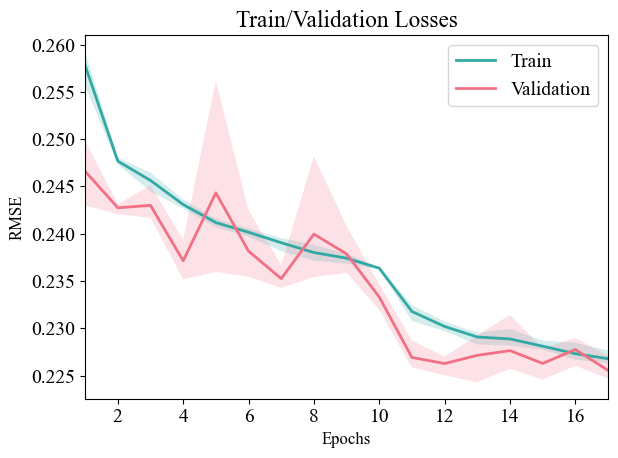

In [18]:
plot_train_test_losses(train_arr,val_arr, title="Train/Validation Losses", x_label="Epochs", y_label="RMSE",
                       min_max_bounds= True, tight_x_lim= True,
                       train_legend = "Train", test_legend = "Validation",
                       save_path=f"results/RUN_{run_name}_{USER}.png")

In [19]:
import csv

In [20]:
# Format the date and time
now = datetime.now()
finish_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", finish_string)

Current Date and Time: 2023-06-09 13:12:10


In [21]:
cv_results["MAE"],cv_results['RMSE'],cv_results["R2"]

([0.17406829114813005, 0.16698577352901445, 0.17063068908496495],
 [0.2271006384687702, 0.22563264138289613, 0.2264513237415439],
 [0.1269412915201953, 0.19467795373749558, 0.17812905650939384])

In [22]:
cv_results_full = {}
cv_results_full['MAE_MEAN'] = np.mean(cv_results['MAE'])
cv_results_full['RMSE_MEAN'] = np.mean(cv_results['RMSE'])
cv_results_full['R2_MEAN'] = np.mean(cv_results['R2'])
cv_results_full['MAE_MEAN'],cv_results_full['RMSE_MEAN'],cv_results_full['R2_MEAN']

(0.1705615845873698, 0.2263948678644034, 0.1665827672556949)

In [23]:
cv_results_full['USE_LSTM_BRANCH'] = USE_LSTM_BRANCH
cv_results_full['NUM_CLIMATE_FEATURES'] = NUM_CLIMATE_FEATURES if USE_LSTM_BRANCH else None
cv_results_full['CSV_FILES'] = CSV_FILES if USE_LSTM_BRANCH else None
cv_results_full['NUM_WORKERS'] = NUM_WORKERS
cv_results_full['TRAIN_BATCH_SIZE'] = TRAIN_BATCH_SIZE
cv_results_full['TEST_BATCH_SIZE'] = TEST_BATCH_SIZE
cv_results_full['LEARNING_RATE'] = LEARNING_RATE
cv_results_full['NUM_EPOCHS'] = NUM_EPOCHS
cv_results_full['LR_SCHEDULER'] = LR_SCHEDULER
cv_results_full['RESNET_VERSION'] = RESNET_VERSION
cv_results_full['REG_VERSION'] = REG_VERSION
cv_results_full['USE_SPATIAL_ATTENTION'] = USE_SPATIAL_ATTENTION
cv_results_full['Best Seed'] = best_seed
cv_results_full['SEEDS'] = SEEDS
cv_results_full['OC_MAX'] = OC_MAX
cv_results_full['USE_SRTM'] = USE_SRTM
cv_results_full['TIME'] = {"start": start_string, "finish": finish_string}
cv_results_full['cv_results'] = cv_results

In [24]:
with open(f"results/RUN_{run_name}_{USER}.json", "w") as fp:
    json.dump(cv_results_full, fp, indent=4)

In [ ]:
# READ JSON FILE
# with open("results/my_dict.json", "r") as fp:
#     my_dict = json.load(fp)

# print(my_dict)

# Analysis

## Save Outputs

### Loading the Best Model
Loading the best model from all the coross validation runs.

In [25]:
load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),filename=f"results/RUN_{run_name}_{USER}.pth.tar")
model.eval()
print("Model loaded")

Loading checkpoint=> Done!
Model loaded


load saved model

In [ ]:
# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_05_T_16_02_Nafiseh.pth.tar') #LSTM 

# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_03_T_09_41_Nafiseh.pth.tar') #GLAM 

# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_02_T_20_57_Nafiseh.pth.tar') #Base

# model.eval()
# print("Model loaded")

In [94]:
test_dl_w_id = DataLoader(test_ds_w_id, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [95]:
# test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/RUN_{run_name}_{USER}.csv")
# test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/onlytest_{run_name}_{USER}.csv")

## Visualize Spatial Attention

In [96]:
if not USE_SPATIAL_ATTENTION or USE_LSTM_BRANCH:
    raise Exception("The Next Part of the Notebook is only available for the model with Spatial Attention and no LSTM Branch")

In [221]:
BATCH_N = 105

IMG_IN_BATCH = 2

In [222]:
batch_loader = BatchLoader(test_dl_w_id)

In [223]:
batch = batch_loader(BATCH_N)
batch[0].shape, batch[1].shape, len(batch[2])

(torch.Size([32, 14, 64, 64]), torch.Size([32]), 32)

In [224]:
import sys
import importlib
importlib.reload(sys.modules['plot_utils'])

<module 'plot_utils' from 'c:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\plot_utils\\__init__.py'>

In [225]:
from plot_utils.plot import *
from PIL import Image

In [226]:
# check if results/attention_maps folder exists if not create it
if not os.path.exists("results/attention_maps"):
    os.makedirs("results/attention_maps")

Point Id: 50243186
torch.Size([32, 1])
torch.Size([32, 1, 8, 8])


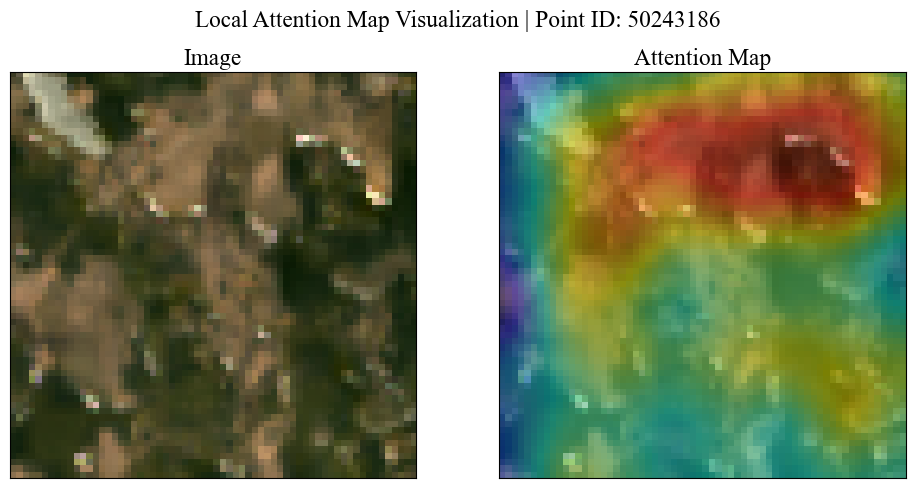

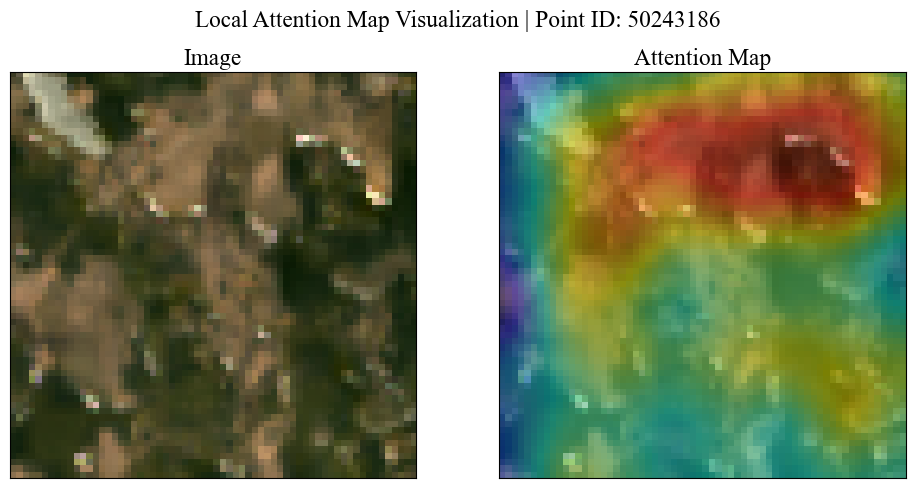

In [229]:
ABS_ATT = False
ALPHA = 0.4
with torch.no_grad():
    pid = batch[2][IMG_IN_BATCH]
    print("Point Id:", pid)
    out = model(batch[0].to(device))
    print(out.shape)
    print(model.cnn.glam.local_spatial_att.att_map.shape)
    img_rgb = batch[0][0].permute(1,2,0)[:,:,[3,2,1]].detach().cpu().numpy()
    img_rgb = convert2uint8(normalize(img_rgb))
    
    att_map = model.cnn.glam.local_spatial_att.att_map
    att_map = F.interpolate(att_map, size=(64, 64), mode='bicubic', align_corners=True)[IMG_IN_BATCH].detach().cpu().numpy()[0]
    att_map = np.abs(att_map) if ABS_ATT else att_map
    att_map = convert2uint8(normalize(att_map))   
    
    colormap = cv2.applyColorMap(att_map, cv2.COLORMAP_JET)
    
    img_colormaped = cv2.addWeighted(img_rgb, 1 - ALPHA, colormap, ALPHA, 0)

    display_images(img_rgb, img_colormaped, ["Image", "Attention Map"], f"Local Attention Map Visualization | Point ID: {pid}", figsize=(10,5))
    

    
    
    .imwrite(f"results/attention_maps/final/_{run_name}_{USER}_pid{pid}_img_lcl_colormaped.png", cv2.cvtColor(img_colormaped, cv2.COLOR_RGB2BGR))
    
    
    

Point Id: 50243186
torch.Size([32, 1])
torch.Size([32, 512, 8, 8])


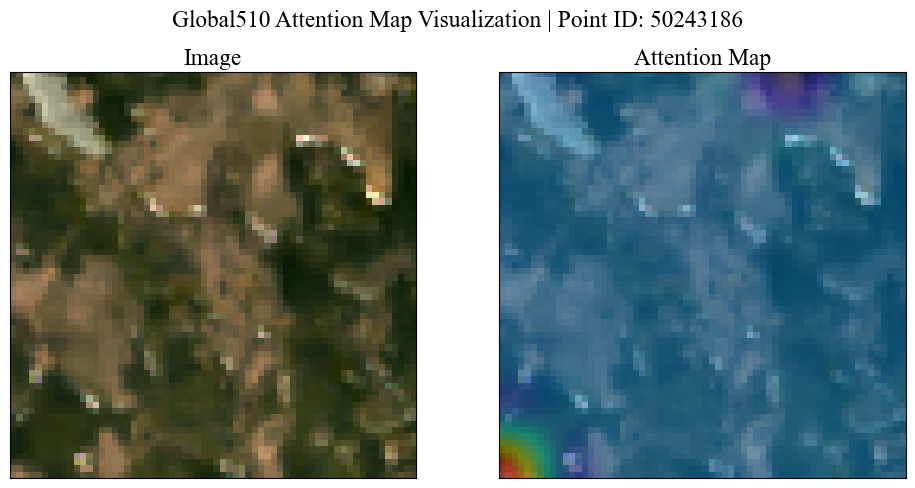

In [228]:
GLOB_ATT_CHANNEL = 510 # ranges between 0 and 511
with torch.no_grad():
    pid = batch[2][IMG_IN_BATCH]
    print("Point Id:", pid)
    out = model(batch[0].to(device))
    print(out.shape)
    print(model.cnn.glam.global_spatial_att.att.shape)
    img_rgb = batch[0][0].permute(1,2,0)[:,:,[3,2,1]].detach().cpu().numpy()
    img_rgb = convert2uint8(normalize(img_rgb))
    
    att_map = model.cnn.glam.global_spatial_att.att
    att_map = F.interpolate(att_map, size=(64, 64), mode='bicubic', align_corners=True)[IMG_IN_BATCH].detach().cpu().numpy()[GLOB_ATT_CHANNEL]
    att_map = np.abs(att_map) if ABS_ATT else att_map
    att_map = convert2uint8(normalize(att_map))   
    
    colormap = cv2.applyColorMap(att_map, cv2.COLORMAP_JET)
    
    img_colormaped = cv2.addWeighted(img_rgb, 1 - ALPHA, colormap, ALPHA, 0)

    display_images(img_rgb, img_colormaped, ["Image", "Attention Map"], f"Global{GLOB_ATT_CHANNEL} Attention Map Visualization | Point ID: {pid}") 
                #    figsize=(10,5), savepath=f"results/attention_maps/final/RUN_{run_name}_{USER}_pid{pid}_glb{GLOB_ATT_CHANNEL}.png")
    
    # # Save img_rgband img_colormaped as jpg files
    # cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_glb{GLOB_ATT_CHANNEL}_rgb.png", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    # cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_glb{GLOB_ATT_CHANNEL}_colormaped.png", cv2.cvtColor(img_colormaped, cv2.COLOR_RGB2BGR))
    
    
    